# Analyse exploratoire de données

In [1]:
# Pour la manipulation des données
import pandas as pd

# Pour les mathématiques
import numpy as np

# Pour les graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Pour visualiser les valeurs manquantes
import missingno as mso

In [2]:
pd.set_option("display.max_columns", 40)

L'analyse exploratoire des données se compose essentiellement de deux grandes étapes: le nettoyage des données, puis l'analyse statistique des données. Mais dans les détails, ce que l'on analyse dépend de ce que l'on compte faire de ces données. Nous verrons deux exemples.

# Exemple 1: analyse de données en vue d'une application de recommandation de produits alimentaires.

## Contexte:

On veut créer une application mobile permettant à un consommateur de savoir si le produit qu'il compte acheter est conforme à son régime alimentaire et qui lui propose si possible un meilleur produit.

En pratique:

* L'utilisateur défini son profil de consommateur parmi un ensemble de profils prédéfinis (par exemple: je recherche des produits avec un bon nutri-score et sans additifs).

* L'application lui indique si le produit qu'il scanne est conforme à son profil.

* L'application lui propose éventuellement un produit de substitution meilleur.

<img src="appli.png" width="300" height="500">

Il faut disposer d'une base de données comportant des informations sur les produits susceptibles d'être scannés et il faut que ces informations soit pertinantes.

Voici les données dont nous nous servirons pour ce premier exemple:

In [3]:
data = pd.read_csv("data/foodfacts.csv", low_memory=False)

### Etape 0: petit aperçu des données

In [4]:
data.shape

(320772, 38)

In [5]:
data.head()

,code,product_name,origins,labels,ingredients_text,allergens,traces,traces_tags,traces_fr,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,categorie,sous_categorie,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,0000000003087,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,28 g (1 ONZ),0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,0.0,0.0,d,NaN,NaN,2243.0,28.57,28.57,NaN,NaN,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,NaN,0.000,0.00129,14.0
2,0000000004559,Peanuts,NaN,NaN,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,NaN,28 g (0.25 cup),0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,0.0,0.0,b,NaN,NaN,1941.0,17.86,0.00,NaN,NaN,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,NaN,0.071,0.00129,0.0
3,0000000016087,Organic Salted Nut Mix,NaN,NaN,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,NaN,28 g (0.25 cup),0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,NaN,0.0,0.0,d,NaN,NaN,2540.0,57.14,5.36,NaN,NaN,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,NaN,0.143,0.00514,12.0
4,0000000016094,Organic Polenta,NaN,NaN,Organic polenta,NaN,NaN,NaN,NaN,35 g (0.25 cup),0.0,[ organic-polenta -> en:organic-polenta ] [...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1552.0,1.43,NaN,NaN,NaN,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Etape 1: nettoyage des données

## Etape 1.1: gérer le manque grossier de données

### Visualisation des valeurs manquantes

<AxesSubplot:>

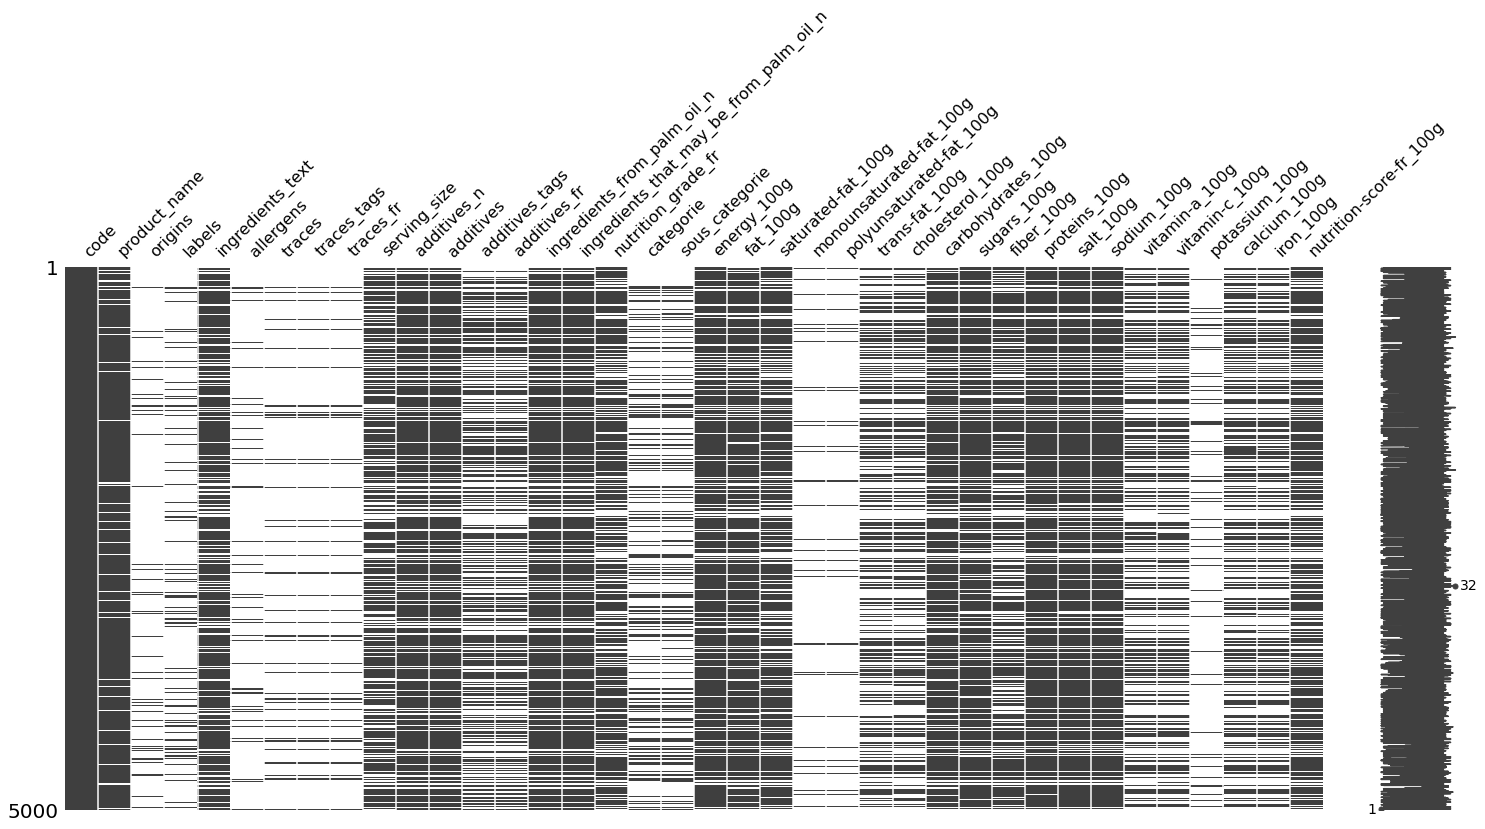

In [6]:
mso.matrix(data.sample(5000))
# Les cases remplies sont en noire, les cases vides en blanc.

On voit que certaines colonnes sont quasiment vides, on ne pourra donc rien en faire. On remarque également certaines lignes quasiment vides.

<AxesSubplot:>

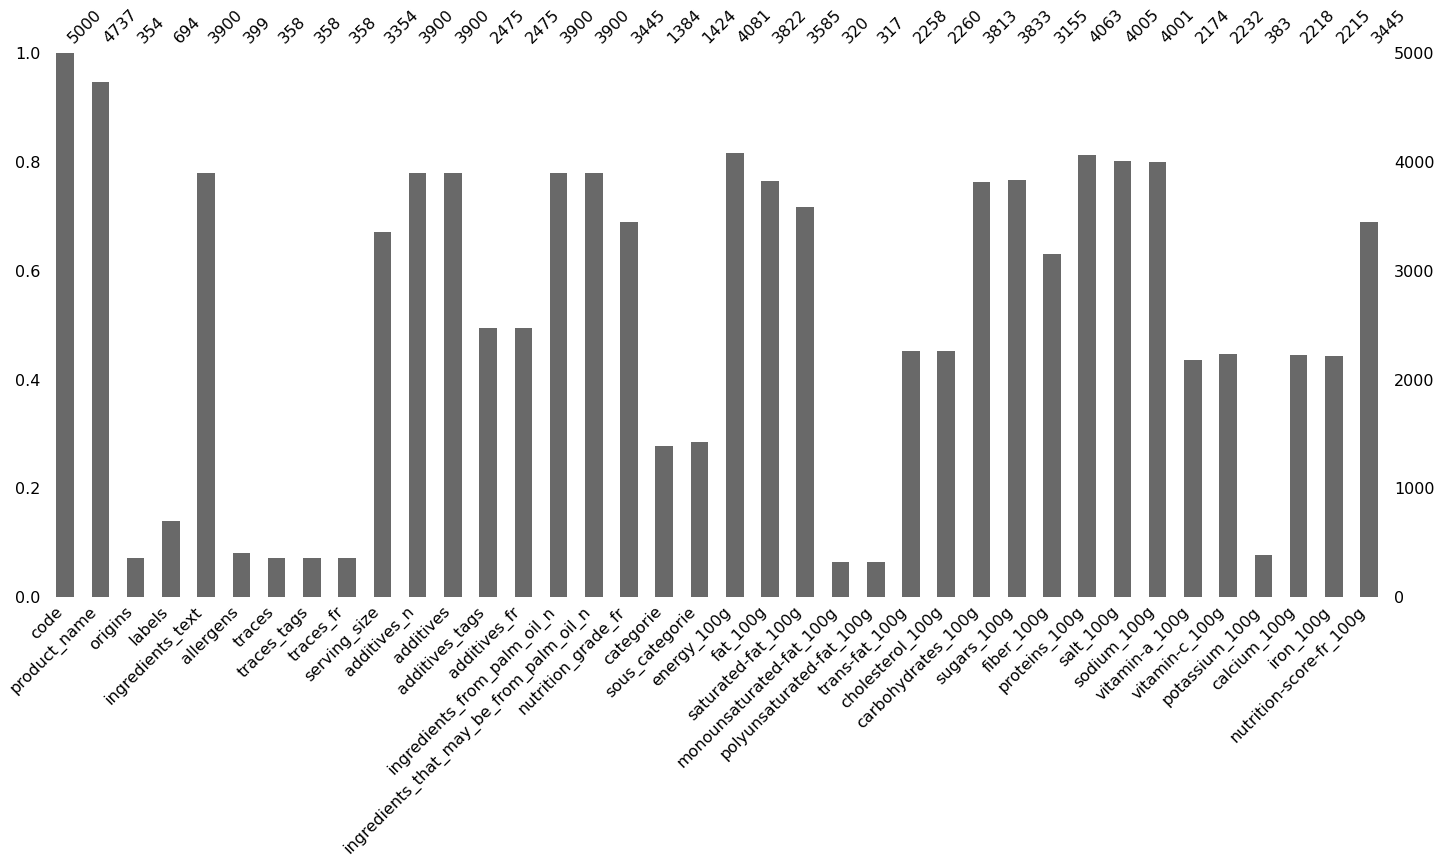

In [7]:
mso.bar(data.sample(5000))

### Suppression de colonnes où il manque trop de valeurs

Au-delà d'une certaine proportion de valeurs manquantes sur une colonne, on supprime la colonne. Le choix de la proportion limite est arbitraire, mais pour cet exemple je vais faire en sorte de conserver les variables 'categorie' et 'sous_categorie' pour la suite.

In [8]:
seuil_colonne = 0.8 # proportion de Nan au-delà de laquelle une colonne sera supprimée

for c in data.columns:
    if data[c].isna().mean() >= seuil_colonne:
        data = data.drop(c, axis=1)

<AxesSubplot:>

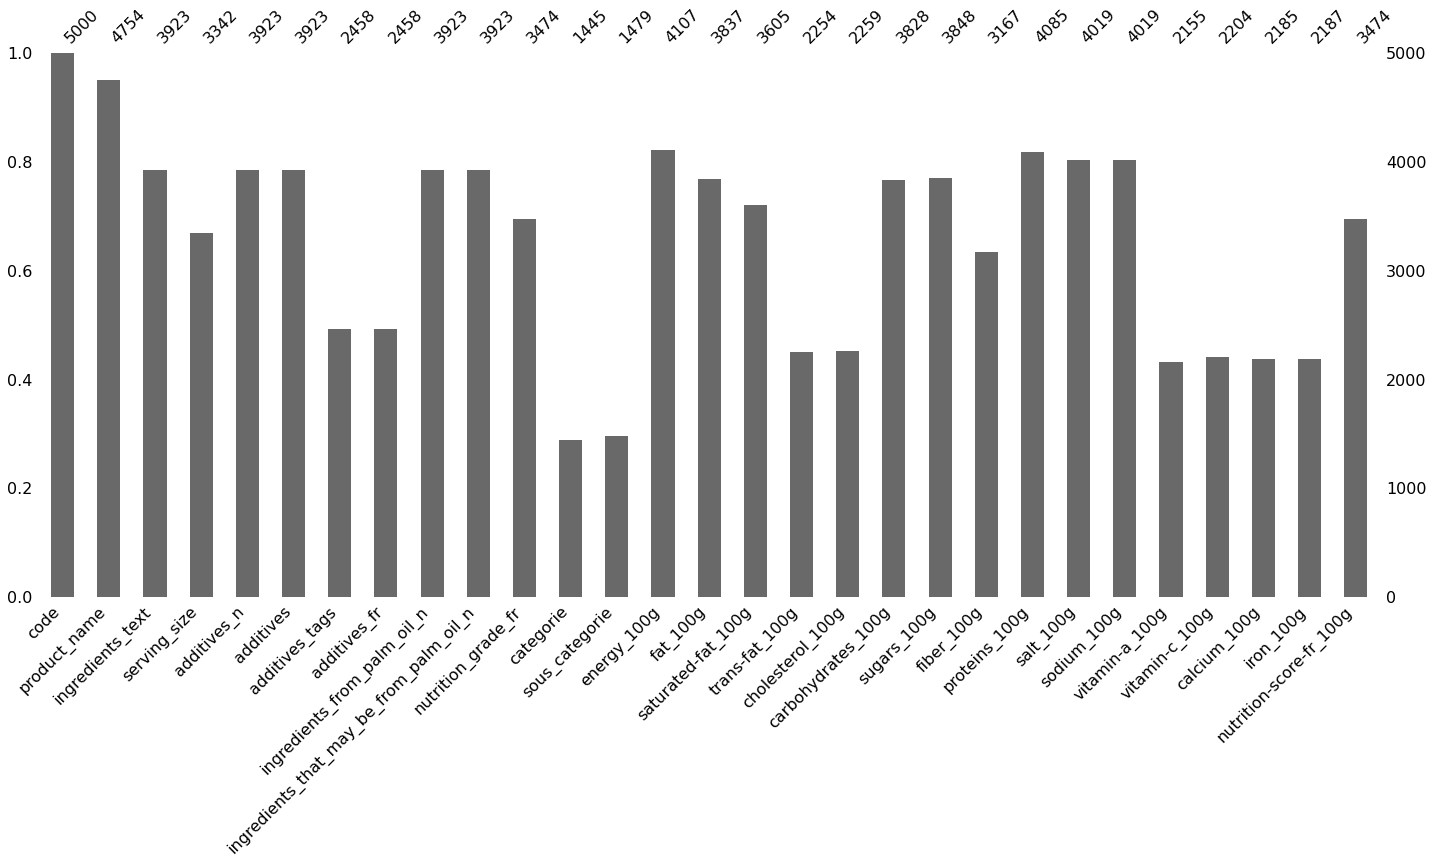

In [9]:
mso.bar(data.sample(5000))

### Suppression de lignes ou il manque trop de valeurs

Nous allons également supprimer les lignes où il manque trop de valeur (plus qu'un certain seuil).

In [10]:
nbre_colonnes = data.shape[1]
nbre_colonnes

29

In [11]:
seuil_ligne = 0.7
nbre_seuil_ligne = np.floor(seuil_ligne * nbre_colonnes)
nbre_seuil_ligne

20.0

In [12]:
data = data.dropna(thresh=nbre_seuil_ligne)

In [13]:
data.shape

(193724, 29)

In [14]:
data.head()

,code,product_name,ingredients_text,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,categorie,sous_categorie,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
1,0000000004530,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,0.0,0.0,d,NaN,NaN,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0
2,0000000004559,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,0.0,0.0,b,NaN,NaN,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0
3,0000000016087,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,NaN,0.0,0.0,d,NaN,NaN,2540.0,57.14,5.36,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0
7,0000000016124,Organic Muesli,"Org oats, org hemp granola (org oats, evaporat...",64 g (0.5 cup),2.0,[ org-oats -> en:org-oats ] [ oats -> en:oa...,"en:e123,en:e307a","E123 - Amarante,E307a - Tocophérol",0.0,0.0,c,NaN,NaN,1833.0,18.75,4.69,NaN,NaN,57.81,15.62,9.4,14.06,0.13970,0.055,NaN,NaN,0.062,0.00422,7.0
12,0000000016872,Zen Party Mix,"Roasted peanuts (peanuts, peanut or canola oil...",30 g (0.25 cup),1.0,[ roasted-peanuts -> en:roasted-peanuts ] [...,en:e100,E100 - Curcumine,0.0,0.0,d,NaN,NaN,2230.0,36.67,5.00,NaN,NaN,36.67,3.33,6.7,16.67,1.60782,0.633,NaN,NaN,0.133,0.00360,12.0


Pour y voir plus clair dans la suite de cet exemple, je vais considérer moins de variables.

In [15]:
data.columns

Index(['code', 'product_name', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'categorie', 'sous_categorie', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [16]:
data = data[['product_name','additives_n','ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'categorie', 'sous_categorie', 'energy_100g', 'fat_100g','saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g','salt_100g']]

### Suppression des doublons

In [17]:
data.shape

(193724, 15)

In [18]:
data = data.drop_duplicates()

In [19]:
data.shape

(181481, 15)

## Etape 1.2: gérer les valeurs problématiques

Il peut y avoir toutes sortes d'erreurs dans un jeu de données: une chaîne de caractère à la place d'une valeur numérique, une valeur manifestement fausse...

On peut commencer par voir les types des éléments des différentes colonnes.

In [20]:
data.dtypes

product_name                                object
additives_n                                float64
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
nutrition_grade_fr                          object
categorie                                   object
sous_categorie                              object
energy_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
carbohydrates_100g                         float64
sugars_100g                                float64
fiber_100g                                 float64
proteins_100g                              float64
salt_100g                                  float64
dtype: object

Les types sont corrects.

### Traitement des chaînes de caractères

Il y a dans notre jeu de données deux variables essentielles pour notre application, les variables 'categorie' et 'sous_categorie', car ce sont elles qui permettent de proposer un produit de substitution similaire au produit scanné.

In [21]:
data['categorie'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Composite foods', 'Beverages', 'Fish Meat Eggs',
       'Cereals and potatoes', 'Milk and dairy products',
       'Fat and sauces', 'Salty snacks', 'fruits-and-vegetables',
       'sugary-snacks', 'cereals-and-potatoes', 'salty-snacks'],
      dtype=object)

On remarque qu'il y a une catégorie 'Sugary snacks' et une catégorie 'sugary-snacks'. Pour un humain il est clair qu'il doit s'agir en fait d'une seule catégorie, mais pour un ordinateur ce n'est pas clair et il faut uniformiser l'écriture des chaînes de caractères. Cette uniformisation dépend des valeurs se trouvant dans le jeu de données, mais il y a souvent les problèmes récurrents suivants: les majuscules/miniscules, les tirets et les espaces multiples consécutifs. 

On écrit toutes les valeurs de ces variables en minuscule, on remplace les tirets par des espaces et on supprime les espaces multiples. De plus on attribut la catégorie (ou sous-catégorie) 'unknown' pour les valeurs non renseignés (nan).

Bien sûr, dans le contexte de notre exemple, on aurait besoin de connaître la sous catégorie de chaque produit pour notre application, mais le jeu de données est comme ça... 

In [22]:
data[['categorie', 'sous_categorie']] = data[['categorie', 'sous_categorie']].fillna('unknown')

In [23]:
import re

In [24]:
def uniformisation(mots):
    words = mots.lower() # minuscule
    words = words.replace("-"," ") # remplace les tirets en espace
    words = re.sub(" +"," ", words) # remplace les espaces multiples en un seul espace
    return words

In [25]:
data['categorie'] = data['categorie'].apply(uniformisation)
data['sous_categorie'] = data['sous_categorie'].apply(uniformisation)

In [26]:
data['categorie'].unique()

array(['unknown', 'fruits and vegetables', 'sugary snacks',
       'composite foods', 'beverages', 'fish meat eggs',
       'cereals and potatoes', 'milk and dairy products',
       'fat and sauces', 'salty snacks'], dtype=object)

In [27]:
data['sous_categorie'].unique()

array(['unknown', 'vegetables', 'biscuits and cakes',
       'pizza pies and quiche', 'sweets', 'sweetened beverages',
       'one dish meals', 'soups', 'meat', 'cereals', 'milk and yogurt',
       'fats', 'cheese', 'dressings and sauces', 'chocolate products',
       'sandwich', 'bread', 'nuts', 'legumes', 'breakfast cereals',
       'appetizers', 'non sugared beverages', 'fruit juices', 'eggs',
       'fish and seafood', 'fruits', 'ice cream', 'processed meat',
       'dried fruits', 'pastries', 'dairy desserts', 'potatoes',
       'artificially sweetened beverages', 'alcoholic beverages',
       'fruit nectars', 'salty and fatty products', 'tripe dishes'],
      dtype=object)

### Traitement des valeurs aberrantes

Il est important de vérifier s'il n'y a pas des valeurs manifestement fausses. Par exemple la variable 'nutrition_grade_fr' contient le nutri-score du produit, donc les valeurs possibles de cette variable sont les lettres a, b, c, d, e (ou alors la valeur n'est pas renseignée).

In [28]:
data['nutrition_grade_fr'].unique()

array(['d', 'b', 'c', 'a', 'e', nan], dtype=object)

Il n'y a pas d'erreur évidente pour cette variable (mais il y a peut-être des erreurs de saisie ou de calcul du nutri-score).

Passons aux variables numériques. Dans notre exemple on a des masses (de glucides, de protéines...) pour 100g de produit. Ces variables prennent forcément des valeurs entre 0 et 100. Nous avons aussi des variables qui doivent prendre des valeurs entières positives (comme le nombre d'additifs).

In [29]:
data['additives_n'].unique()

array([ 0.,  2.,  1.,  3.,  5., 10.,  4., 11.,  8.,  7.,  6.,  9., nan,
       13., 18., 22., 19., 17., 25., 12., 21., 14., 16., 20., 24., 23.,
       15., 26., 28., 27., 29., 31.])

In [30]:
data['ingredients_from_palm_oil_n'].unique()

array([ 0.,  1., nan,  2.])

In [31]:
data['ingredients_that_may_be_from_palm_oil_n'].unique()

array([ 0.,  1., nan,  2.,  5.,  3.,  4.,  6.])

Il ni a pas de problème concernant les valeurs devant être des nombres entiers.

In [32]:
data.describe() 
# Les valeurs minimums et maximums de chaque variable nous indiqueront s'il y a des valeurs aberrantes évidentes.

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,181212.000000,181212.000000,181212.000000,1.812760e+05,180902.000000,179045.000000,180926.000000,179920.000000,161221.000000,181047.000000,181369.000000
mean,2.086286,0.022675,0.061133,1.191802e+03,13.000132,4.809629,33.745602,15.277413,2.853538,7.688531,1.781160
std,2.558771,0.150745,0.283874,7.675216e+03,15.551816,7.108189,28.232436,19.700483,4.352537,7.939897,151.690547
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,-6.700000,-3.570000,0.000000
25%,0.000000,0.000000,0.000000,4.560000e+02,0.850000,0.000000,7.200000,1.500000,0.000000,1.900000,0.111760
50%,1.000000,0.000000,0.000000,1.197000e+03,7.140000,1.790000,25.000000,5.600000,1.600000,5.630000,0.683260
75%,3.000000,0.000000,0.000000,1.715000e+03,21.430000,7.100000,59.900000,23.810000,3.600000,10.710000,1.400000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,210.000000,209.380000,134.000000,178.000000,100.000000,64312.800000


Il y a manifestement des problèmes...

In [33]:
data[data['fat_100g'] == data['fat_100g'].max()]

,product_name,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,categorie,sous_categorie,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
112681,Premium Extra Virgin Olive Oil,0.0,0.0,0.0,e,unknown,unknown,110579.0,714.29,100.0,NaN,0.0,0.0,0.0,0.0


On va remplacer les valeurs manifestement fausses par des Nan afin qu'elles ne faussent pas l'analyse statistique. Toutes les valeurs de masse pour 100g doivent être comprise entre 0 et 100. Les valeurs d'énergie pour 100g doivent être comprise entre 0 et 900 kcal. 

In [34]:
quantite_100g = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g']
quantite_et_energie_100g = ['energy_100g','fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g']

In [35]:
# On va compter le nombre de valeurs remplacées par Nan
liste = [data[c].isna().value_counts().to_list()[1] for c in quantite_et_energie_100g]
ecart = pd.DataFrame(liste, index =quantite_et_energie_100g, columns=['nbre_de_nan_avant'])

In [36]:
data.loc[(data['energy_100g'] > 900), 'energy_100g'] = np.nan
data.loc[(data['energy_100g'] < 0), 'energy_100g'] = np.nan

In [37]:
for c in quantite_100g:
    data.loc[(data[c] > 100), c] = np.nan
    data.loc[(data[c] < 0), c] = np.nan

In [38]:
liste_apres = [data[c].isna().value_counts().to_list()[1] for c in quantite_et_energie_100g]
ecart['nbre_de_nan_après'] = pd.DataFrame(liste_apres, index =quantite_et_energie_100g, columns=['nbre_de_nan_après'])['nbre_de_nan_après']
ecart['difference']=ecart['nbre_de_nan_après']-ecart['nbre_de_nan_avant']
ecart

,nbre_de_nan_avant,nbre_de_nan_après,difference
energy_100g,205,72210,72005
fat_100g,579,581,2
saturated-fat_100g,2436,2438,2
carbohydrates_100g,555,563,8
sugars_100g,1561,1572,11
fiber_100g,20260,20262,2
proteins_100g,434,435,1
salt_100g,112,160,48


On remarque qu'il y avait beaucoup de valeurs aberrantes pour l'énergie comparé aux autres variables.

Après cette étape nous avons à nouveau des valeurs manquantes et la démarche à adopter dépend de ce que l'on veut faire de ces données. 

# Etape 2: analyse statistique des données

Notre application aura pour but de proposer a l'utilisateur des produits "meilleurs", en un certain sens. Encore faut-il qu'il y ait des produits "meilleurs" dans la base de données de l'application. Imaginons que l'on veuille que l'application propose des produits avec un bon Nutri-Score. Si la base de donnée ne contient quasiment que des produits avec un mauvais Nutri-Score alors l'application risque de ne proposer à l'utilisateur que des produits "un peu moins mauvais" et l'intérêt sera très limité. Nous allons donc dans un premier temps décrire les données afin de voir si on peut produire une application à partir des différentes variables

## Visualisation graphique des données

## Nutri-score

In [39]:
data['nutrition_grade_fr'].value_counts()

d    50435
c    36897
e    34445
a    28338
b    26771
Name: nutrition_grade_fr, dtype: int64

<AxesSubplot:ylabel='nutrition_grade_fr'>

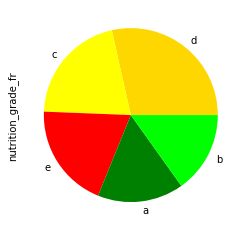

In [40]:
couleur=['#ffd700','#ffff00','#ff0000','#008000', '#00ff00']
data['nutrition_grade_fr'].value_counts().plot(kind='pie', colors=couleur)

[Text(0.5, 1.0, 'Nutri-Score')]

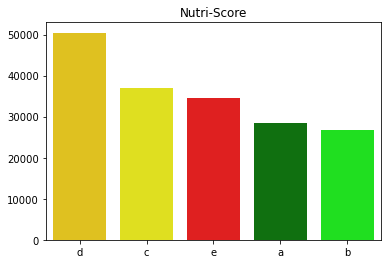

In [41]:
dico_couleur = {'d':'#ffd700','c':'#ffff00','e':'#ff0000','a':'#008000', 'b':'#00ff00'}
comptage = data['nutrition_grade_fr'].value_counts()
sns.barplot(x=comptage.index, y=comptage.values, palette=dico_couleur).set(title='Nutri-Score')

On constate que toutes les valeurs de Nutri-Score sont représentées en grandes quantités, même s'il y a plus de produits avec un mauvais Nutri-Score. Il est donc envisageable que notre application recommande des produit avec un bon Nutri-Score. De plus il peut être intéressant de recommander une catégorie de produits ayant en général un bon nutri-score.

<AxesSubplot:xlabel='count', ylabel='categorie'>

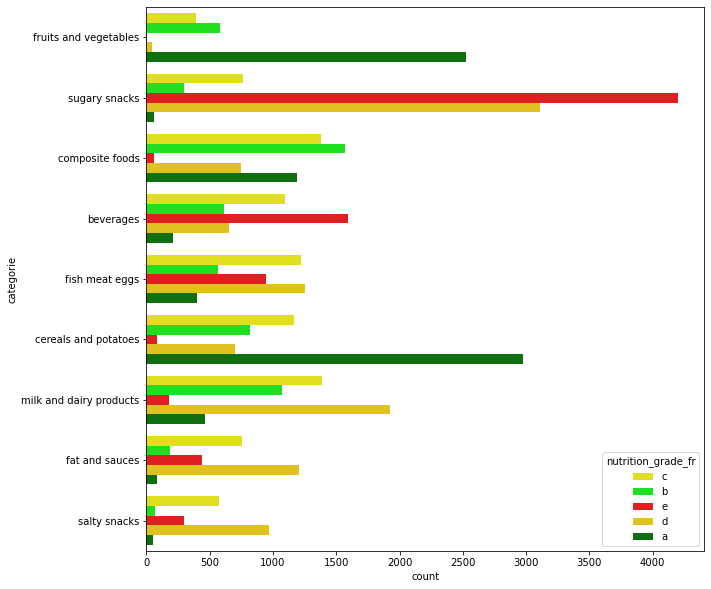

In [42]:
plt.figure(figsize=(10,10))
sns.countplot(y='categorie', hue='nutrition_grade_fr', data=data[data['categorie']!='unknown'], palette=dico_couleur)

<AxesSubplot:xlabel='count', ylabel='sous_categorie'>

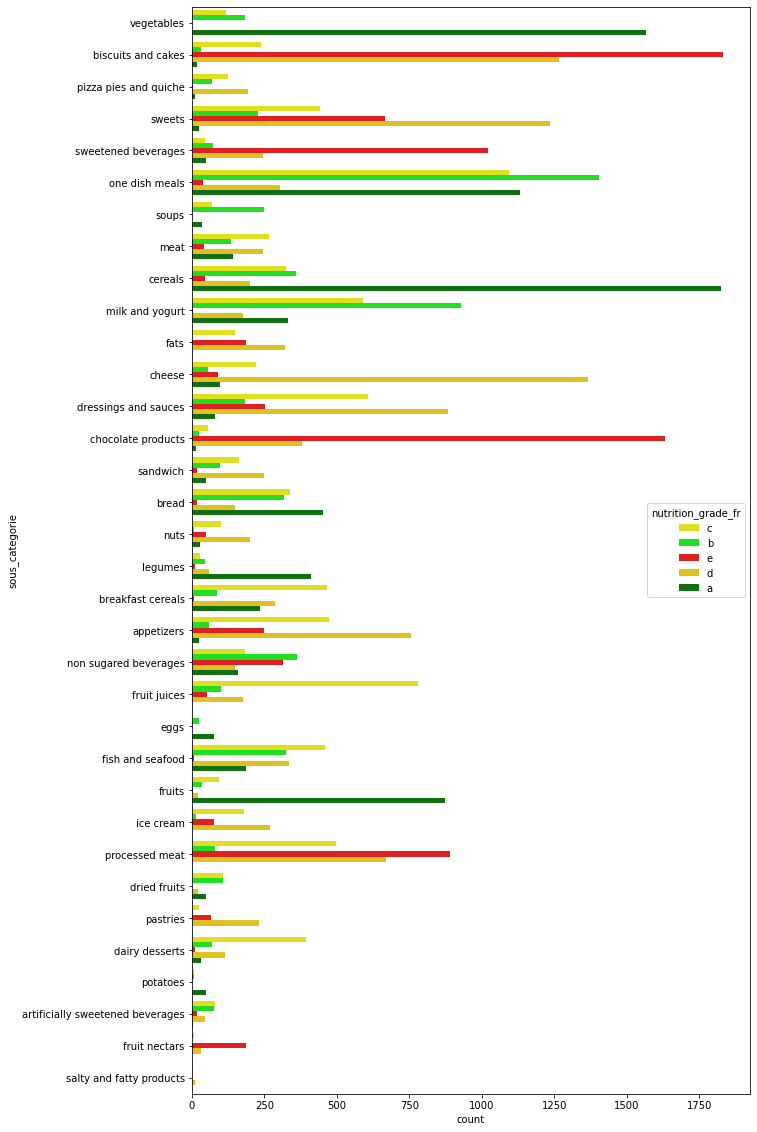

In [43]:
plt.figure(figsize=(10,20))
sns.countplot(y='sous_categorie', hue='nutrition_grade_fr', data=data[data['categorie']!='unknown'], palette=dico_couleur)

## Additifs

In [44]:
data['additives_n'].value_counts()

0.0     59063
1.0     36872
2.0     29694
3.0     18900
4.0     11911
5.0      8202
6.0      5309
7.0      3471
8.0      2478
9.0      1664
10.0     1077
11.0      768
12.0      495
13.0      343
14.0      292
15.0      207
16.0      115
17.0       99
18.0       66
19.0       48
20.0       46
22.0       26
21.0       20
23.0       14
25.0       11
24.0       10
31.0        3
26.0        2
28.0        2
27.0        2
29.0        2
Name: additives_n, dtype: int64

Il n'y aurait pas un grand intérêt à distinguer les produits contenant 29 additifs des produits qui en contiennent 28... 

In [45]:
def classification_nbre_additifs(n):
    if n == 0:
        return 'aucun'
    elif n <= 3 :
        return '1 à 3'
    elif n <= 6:
        return '4 à 6'
    elif n <= 9:
        return '7 à 9'
    else : 
        return '10+'

[Text(0.5, 1.0, "Nombre d'additifs")]

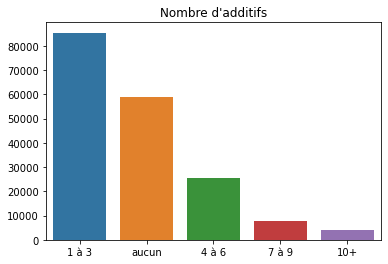

In [46]:
comptage = data['additives_n'].apply(classification_nbre_additifs).value_counts()
sns.barplot(x=comptage.index, y=comptage.values).set(title='Nombre d\'additifs')

Il est envisageable que l'application recommande des produit en fonction du nombre d'additifs qu'ils contiennent suivant le découpage en classes ci-dessus. 

## Huile de palme

<AxesSubplot:title={'center':"Ingrédients contenants de l'huile de palme"}>

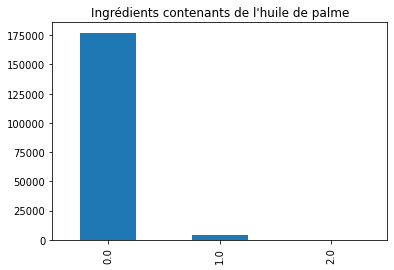

In [47]:
data['ingredients_from_palm_oil_n'].value_counts().plot(kind='bar', title='Ingrédients contenants de l\'huile de palme')

Dans le cas de la présence d'huile de palme, il ne semble pas pertinent de s'intéresser au nombre exact d'ingrédient contenant de l'huile de palme, mais seulement de répondre à la question: y-a-t'il, oui ou non, des ingrédients à base d'huile de palme?

In [48]:
data['ingredients_that_may_be_from_palm_oil_n'].value_counts()

0.0    171859
1.0      7951
2.0      1126
3.0       234
4.0        38
5.0         3
6.0         1
Name: ingredients_that_may_be_from_palm_oil_n, dtype: int64

In [49]:
def classification_nbre_palm_oil_maybe(n):
    if n == 0:
        return 'aucun'
    elif n == 1 :
        return '1'
    elif n == 2:
        return '2'
    else : 
        return '3 à 6'

[Text(0.5, 1.0, "Ingrédients pouvant contenir de l'huile de palme")]

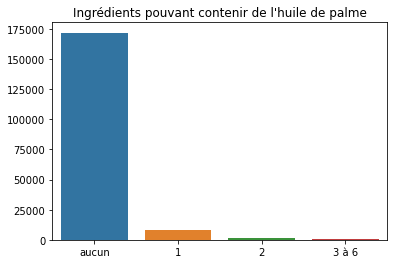

In [50]:
comptage = data['ingredients_that_may_be_from_palm_oil_n'].apply(classification_nbre_palm_oil_maybe).value_counts()
sns.barplot(x=comptage.index, y=comptage.values).set(title='Ingrédients pouvant contenir de l\'huile de palme')

Dans le cas de la présence potentielle d'huile de palme, il ne semble pas pertinent de s'intéresser au nombre exact d'ingrédient pouvant contenir de l'huile de palme, mais seulement de répondre à la question: y-a-t'il, oui ou non, des ingrédients susceptible de contenir de l'huile de palme?

Finalement, concernant la présence d'huile de palme, il serait plus pertinant d'utiliser une seule variable prennant trois valeurs possibles: oui, non, peut-être.

## Valeurs nutritionnelles pour 100g

Cette section est là pour indiquer succintement (toutes les variables ne seront pas analysées) des représentations graphiques pour des variables continues mais elle n'est pas très réaliste dans le contexte de notre exemple. En effet il semble exagérer de recomander un produit ayant 35g de glucides pour 100g au lieu de 36g et en fait le nutri-score constitue une synthèse pertinente des valeurs nutritionnelles des produits, mais peut-être que, par exemple, proposer des produits faibles en sel serait intéressant. En tout cas il faut garder en tête qu'on ne fait pas une analyse statistique juste pour le plaisir d'en faire mais bien parce qu'on cherche quelque chose. 

### Analyse univariée

On peut regrouper dans un tableau les principaux indicateurs statistiques concernant les variables qui nous intéressent.

In [51]:
data[quantite_et_energie_100g].describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,72210.000000,180900.000000,179043.000000,180918.000000,179909.000000,161219.000000,181046.000000,181321.000000
mean,399.047195,12.994227,4.807530,33.740943,15.276036,2.852511,7.688593,1.289563
std,246.002022,15.440154,7.080201,28.223255,19.695156,4.330585,7.939875,4.057015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,197.000000,0.850000,0.000000,7.200000,1.500000,0.000000,1.900000,0.111760
50%,360.000000,7.140000,1.790000,25.000000,5.600000,1.600000,5.630000,0.680720
75%,587.000000,21.430000,7.100000,59.900000,23.810000,3.600000,10.710000,1.400000
max,900.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


Mais les graphiques sont souvent plus parlant qu'un tableau de valeurs. Les histogrammes et les boxplots sont très efficaces pour représenter les données continues. On ne fera pas des graphiques pour toutes les variables mais seulement quelques exemples (c'est toujours le même principe).

In [52]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
# Un point rouge indiquera la moyenne dans les boxplots

Text(0.5, 1.0, 'glucides pour 100g')

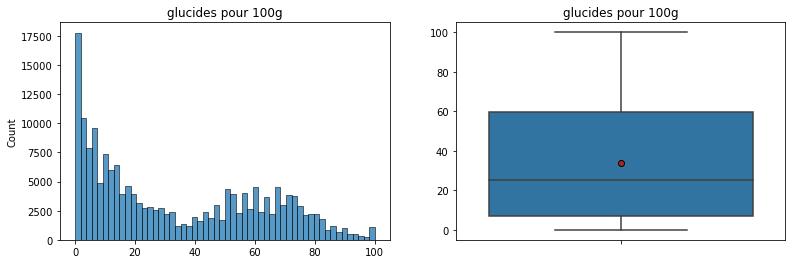

In [53]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
sns.histplot(data=data, x='carbohydrates_100g').set(xlabel='')
plt.title('glucides pour 100g')
plt.subplot(1,2,2)
sns.boxplot(data=data[['carbohydrates_100g']], showmeans=True, meanprops=meanprops).set(xticklabels=[])
plt.title('glucides pour 100g')

On peut faire des représentations graphiques séparées pour chacune des variables comme ci-dessus pour les glucides, mais on peut aussi comparer la dispersion interne des différentes variables commme ci-dessous.

<AxesSubplot:>

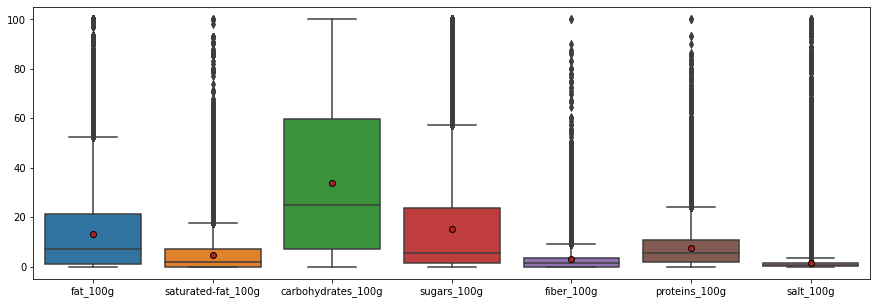

In [54]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data[quantite_100g], showmeans=True, meanprops=meanprops)

### Analyse bivariée

Lors d'une analyse bivariée on cherche à voir s'il n'y aurait pas une dépendance entre deux variables. Dans l'exemple ci-dessous, où on a représenté la dispersion des valeurs de lipides pour 100g pour chaque catégorie, on remarque que les fruits et légumes ont à peu près tous la même quantité de lipides pour 100g alors qu'il y a une très grande dispersion au sein des produit "fat and sauces".

<AxesSubplot:xlabel='fat_100g', ylabel='categorie'>

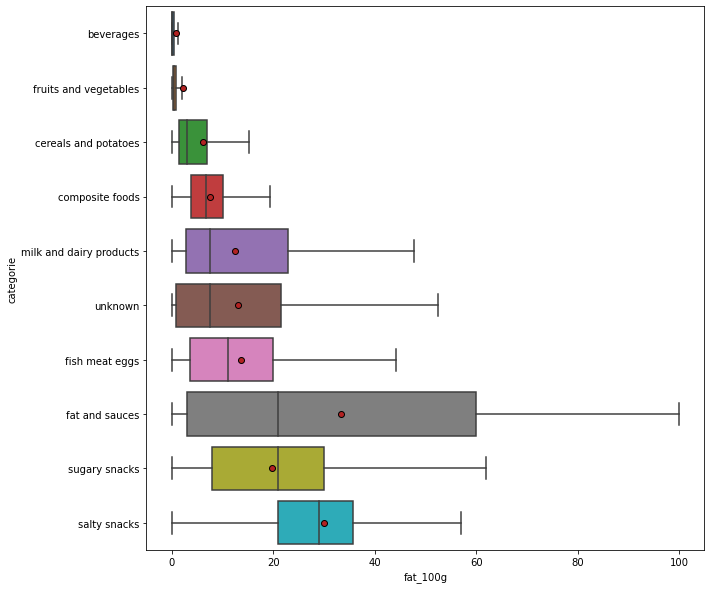

In [55]:
ordre_fat = data.groupby('categorie')['fat_100g'].median().sort_values().index

plt.figure(figsize=(10,10))
sns.boxplot(x="fat_100g",y="categorie", showfliers=False, showmeans=True, meanprops=meanprops,
            orient='h', order=ordre_fat, data=data)

Les 3 dernières sections de cette exemple sont là à titre indicatif mais ne contiennent pas de mise en pratique.

## Effectuer des tests statistiques

Ceci entre dans le cadre de l'analyse bivariée. Plutôt que de juger "à l'oeil" si la catégorie à une influence sur les valeurs nutritionnelles (comme dans la section précédente) il est plus rigoureux de réaliser un test statistique, en l'occurence une analyse de la variance ANOVA.

## Traitement des valeurs manquantes

Parfois il n'est pas nécessaire d'intervenir. Dans notre exemple, imaginez qu'il y ait quelques produits dont on connaisse le nombre d'additifs, d'ingrédients contenant de l'huile de palme,..., mais qu'il manque juste la quantité de graisses saturées pour 100g. On peut laisser ça comme ça parce que notre application pourra quand même faire quelque chose de ce produit. 

En revanche s'il manque beaucoup de valeurs sur un même produit, ou qu'il manque une valeur esentielle sur un produit, ou que beaucoup de produits on une même variable non renseignée, alors il va falloir faire quelque chose. Il y a plusieurs façon de procéder. On peut essayer de récupérer les données manquantes (pas facile et parfois coûteux). On peut donner des valeurs là où il n'y en a pas, mais pas n'importe comment, par exemple on peut remplacer les valeurs manquantes pour une variable par la médiane de la variable, mais ça dépend du contexte: dans le cas de notre application, il ne faudrait pas tromper les consommateurs. On peut aussi être contraint de supprimer un individu ou une variable de notre jeu de donnée.

## Réduction de dimension

Il peut être intéressant de réduire le nombre de variable au moyen d'une méthode comme l'ACP (analyse en composantes principales).

# Exemple 2: analyse exploratoire de données destinées à entraîner un modèle de machine learning

Dans cet exemple, on souhaite développer un algorithme de machine learning permettant de prédire si un passager donné du titanic à survécu ou non. Pour développer notre modèle nous allons utiliser un jeu de données pour l'entraînement et un autre pour le test. Il est important que les jeux de données d'entraînement et de test aient, en proportion, des individus similaires: il ne faudrait pas que quasiment tous les hommes se trouvent dans le jeu d'entraînement, et que quasiment toutes les femmes se trouvent dans le jeu de test. Dans cet exemple, l'analyse exploratoire a en particulier pour but de vérifier que les deux jeux de données sont bien similaires.

### Les deux jeux de données

In [56]:
train = pd.read_csv('data/titanic_train.csv')
test = pd.read_csv("data/titanic_test.csv")

In [57]:
train.shape, test.shape

((891, 12), (418, 11))

In [58]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Valeurs manquantes

<AxesSubplot:>

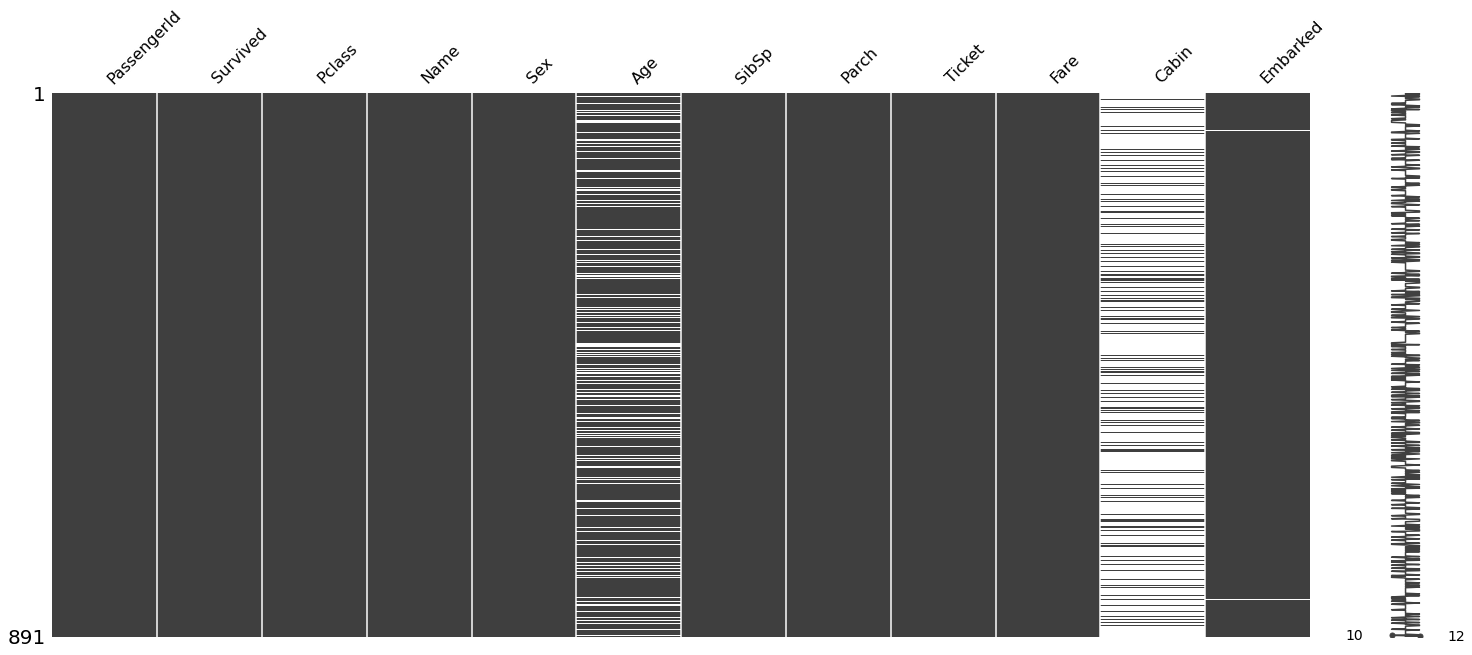

In [60]:
mso.matrix(train)

<AxesSubplot:>

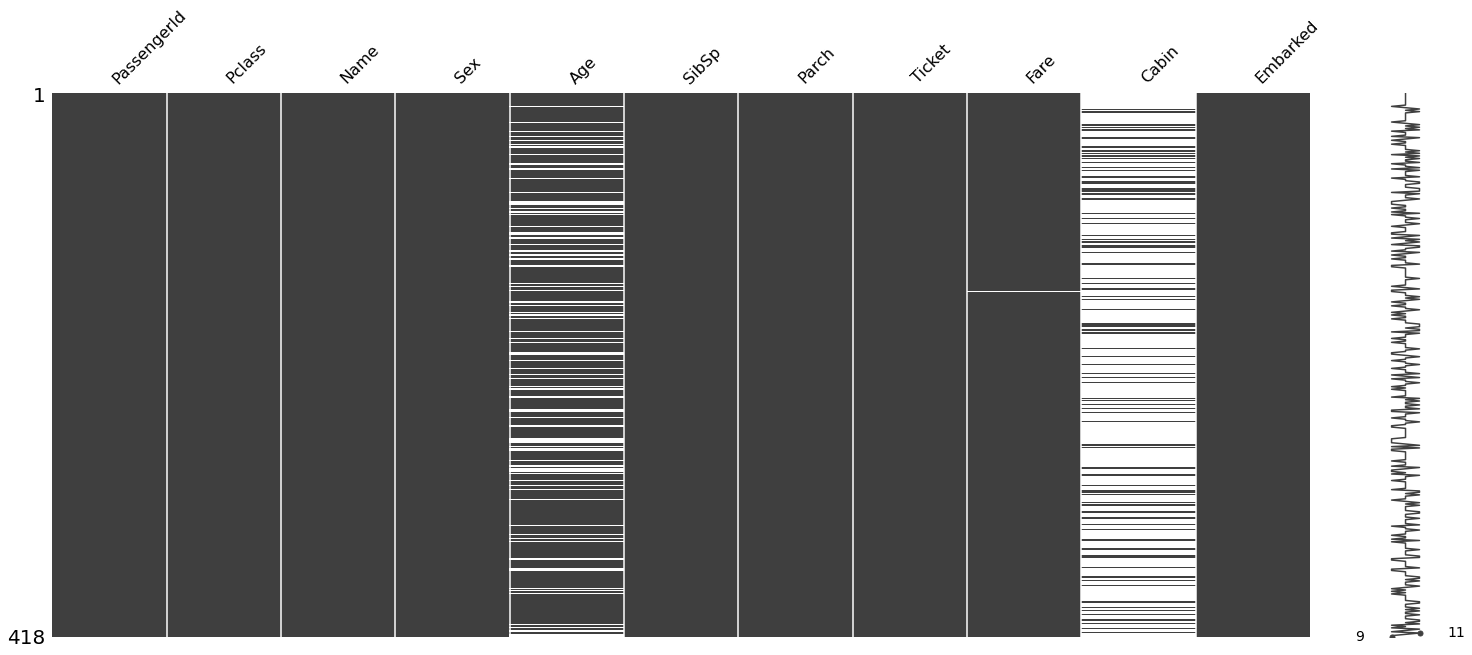

In [61]:
mso.matrix(test)

### Quelques comparaisons

In [62]:
def compare_barplot(df1, df2, colonne):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    comptage = df1[colonne].value_counts()
    sns.barplot(x=comptage.index, y=comptage.values, ax=axs[0]).set(title=colonne)
    comptage=df2[colonne].value_counts()
    sns.barplot(x=comptage.index, y=comptage.values, ax=axs[1]).set(title=colonne)

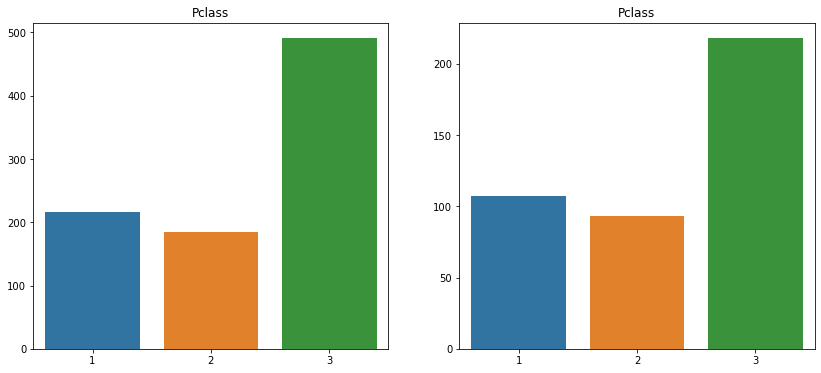

In [63]:
compare_barplot(train, test, 'Pclass')

On remarque que les données d'entraînement et de tests sont très similaires en ce qui concrene la variable 'Pclass'. On continue... 

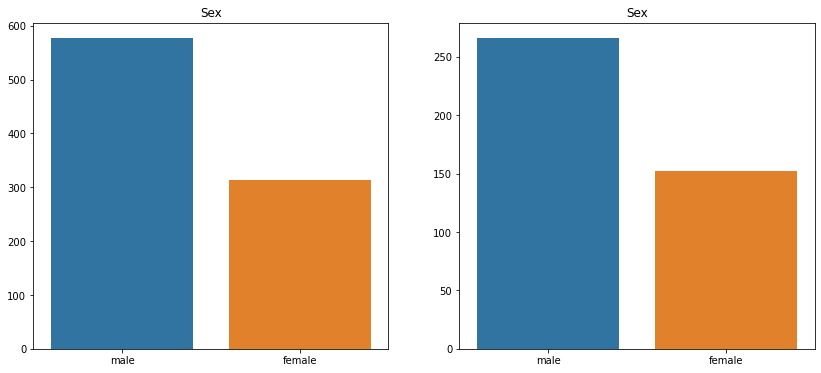

In [64]:
compare_barplot(train, test, 'Sex')

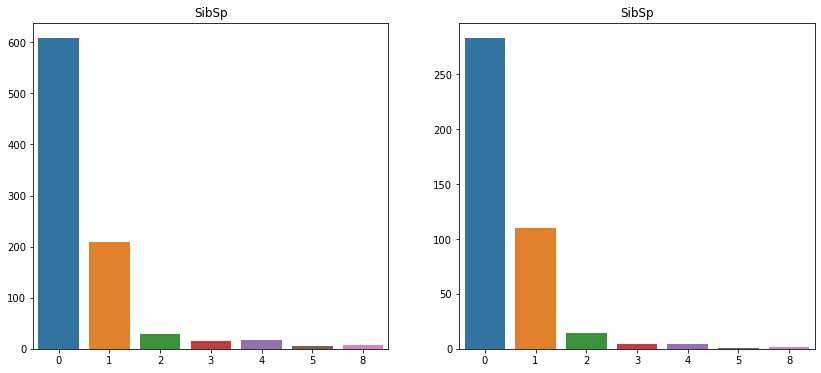

In [65]:
compare_barplot(train, test, 'SibSp')

Etc...